In [62]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import kurtosis
from matplotlib import rc
import scipy.stats as st
%matplotlib inline
rc('text', usetex=True)

class Data():
    
    def __init__(self, data):
        self.data = data
        self.shape = self.data.shape
        self.t = self.extract_t()
        self.tn = self.extract_tn()
        self.q = self.extract_q()
        self.th = self.extract_th()
        
    def __str__(self):
        self.shape = self.data.shape
        return "{} lines of {} variables".format(self.shape[0], self.shape[1])
        
    def extract_t(self):
        return self.data[:,:3]*1000
        
    def extract_tn(self):
        return np.linalg.norm(self.t, axis=1)
    
    def extract_q(self):
        return self.data[:,3:6]
    
    def extract_th(self):
        return self.data[:,6]*180/np.pi
    
    def cut_serie(self, serie, indexes):
        return np.array([x for i, x in enumerate(serie) if i in indexes])
    
    def cut(self, indexes, verbose=True):
        initial = self.data.shape[0]
        self.data = self.cut_serie(self.data, indexes)
        self.t = self.cut_serie(self.t, indexes)
        self.tn = self.cut_serie(self.tn, indexes)
        self.q = self.cut_serie(self.q, indexes)
        self.th = self.cut_serie(self.th, indexes)
        final = self.data.shape[0]
        if verbose:
            print("Reducing data from {} to {} ({:.2f}%)".format(initial, final, 100*final/initial))
        
    def get_stat(self, serie):
        return np.mean(serie), np.std(serie)
    
    def interval(self, data, conf):
        output = np.zeros([len(data), 2])
        for i in range(len(data)):
            m, s = self.get_stat(data[:i+1])
            output[i,:] = st.t.interval(conf, i+1, m, s)
        return output

class Reader():
    
    def __init__(self, file, name='', conf=[0, 1, 3], std=True):
        self.file = file
        self.name = name
        self.data = Data(self.read_log())
        self.update_dim() 
        print(self)
        self.auto(conf, std)
        
    def __str__(self):
        self.update_dim()
        return("File {} contains {}.".format(self.file, self.data))
        
    def read_log(self):
        with open(self.file) as f:
            data = [[float(n) for n in l.split()] for l in f]
        return np.array(data)
    
    def update_dim(self):
        self.dim = self.data.shape
        self.rows, self.cols = self.dim
        
    def hist(self, data, bins=100, title='', x='', y='samples (in %)', gauss=False):
        plt.figure(figsize=[10,5])
        m, s = self.data.get_stat(data)
        if gauss:
            gauss = np.random.normal(m, s, bins*10000)
            _ = plt.hist(gauss, bins, normed=1, color=[0,0,0,0.5])
        _ = plt.hist(data, bins, normed=1, color=[0,0.3,0.8,0.8])
        plt.title(title + ' (mean: {:.2f}, std: {:.2f})'.format(m, s))
        plt.xlabel(x)
        plt.ylabel(y)
        
    def plot_time(self, data, title='', xlab='samples', ylab='', conf=[0, 0.68, 0.95, 0.997], std=False):
        plt.figure(figsize=[10,5])
        m, s = self.data.get_stat(data)
        plt.plot(data, label='measures')
        
        for x in conf:
            if not std:
                interval = self.data.interval(data, x)
                if x == 0:
                    plt.plot(range(len(data)), interval[:,0], 'r', label='mean')
                else:
                    col = (1, x**8, 0)
                    plt.plot(range(len(data)), interval[:,0], '--', c=col, label=r'{:.1f}\%'.format(100*x))
                    plt.plot(range(len(data)), interval[:,1], '--', c=col, label='_nolegend_')
            else:
                if x == 0:
                    plt.plot([0, len(data)], [m, m], 'r', label='mean')
                else:
                    col = (1, 1/(1+x), 0)
                    plt.plot([0, len(data)], [m-x*s, m-x*s], '--', c=col, label=r'{:d} \sigma'.format(x))
                    plt.plot([0, len(data)], [m+x*s, m+x*s], '--', c=col, label='_nolegend_')                
        plt.title(title)
        plt.xlabel(xlab)
        plt.ylabel(ylab)
        m = np.min(data)
        M = np.max(data)
        plt.ylim([(3*M-m)/2, (3*m-M)/2])
        plt.legend()
        
    def cut_percentile(self, data, bounds):
        if len(bounds) == 1:
            b = [bounds, 100-bounds]
        else:
            b = bounds
        b.sort()
        p = [np.percentile(hist[1], b[0]), np.percentile(hist[1], b[1])]
        return np.array([i for i in data if (i >= p[0] and i <= p[1])]), np.array([i for i in range(len(data)) if (data[i] >= p[0] and data[i] <= p[1])])
    
    def cut(self, data, bounds):
        bounds.sort()
        return np.array([i for i in data if (i >= bounds[0] and i <= bounds[1])]), np.array([i for i in range(len(data)) if (data[i] >= bounds[0] and data[i] <= bounds[1])])
    
    def outliers(self, ref, bounds):
        _, indexes = self.cut(ref, bounds)
        self.data.cut(indexes, verbose=True)
        
    def auto(self, conf=[0, 1, 3], std=True):
        self.outliers(self.data.tn, [-200, 200])
        self.plot_time(self.data.tn, title=self.name + ' - Distance', ylab='distance (in mm)', conf=conf, std=std)
        self.plot_time(self.data.th, title=self.name + ' - Angle', ylab=r'angle (in ^o)', conf=conf, std=std)
        self.hist(self.data.tn, 100, 'Translation error', 'distance (in mm)', gauss=1)
        self.hist(self.data.th, 100, 'Rotation error', r'angle (in ^o)', gauss=1)

File cam3_cam2_nofiltering.log contains 1317 lines of 7 variables.
Reducing data from 1317 to 1253 (95.14%)


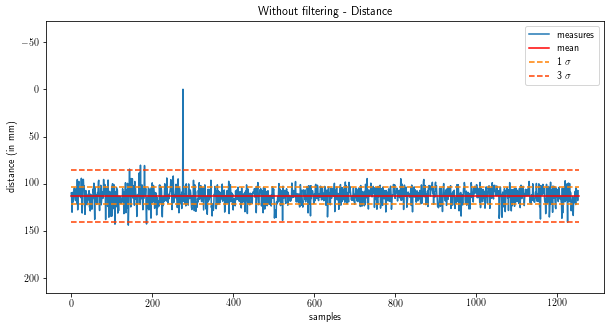

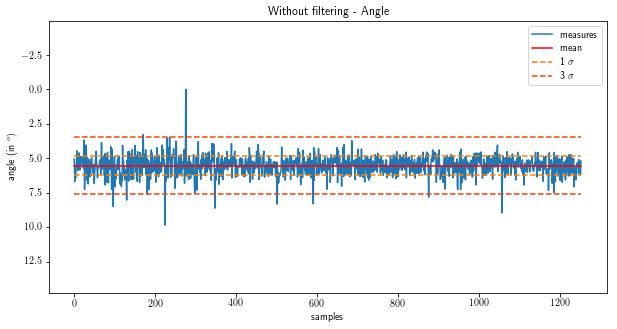

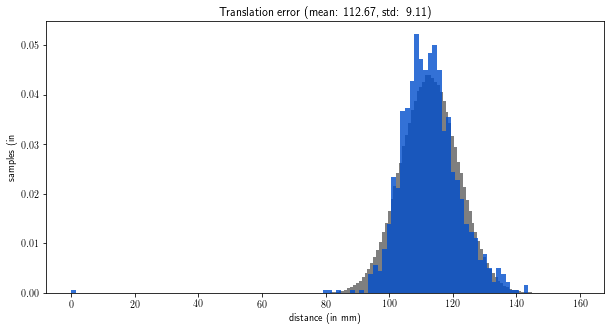

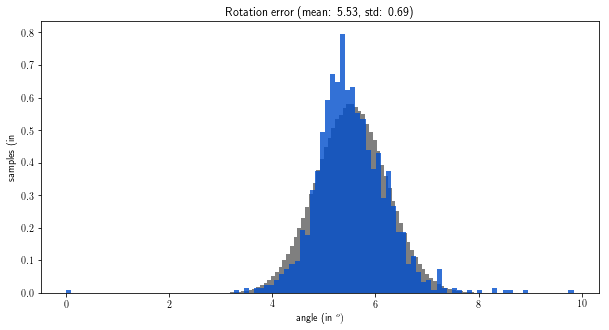

In [63]:
R = Reader('cam3_cam2_nofiltering.log', 'Without filtering')

File cam3_cam2-average.log contains 1420 lines of 7 variables.
Reducing data from 1420 to 1418 (99.86%)


/users/promo2017/smaillot/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/users/promo2017/smaillot/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


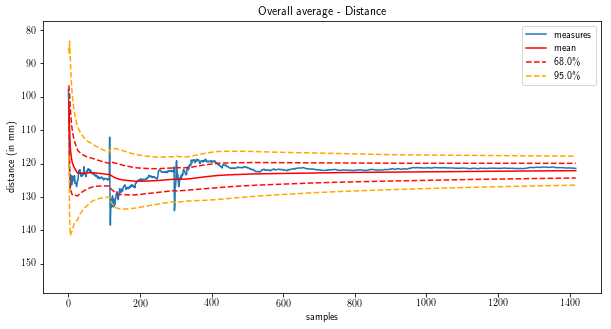

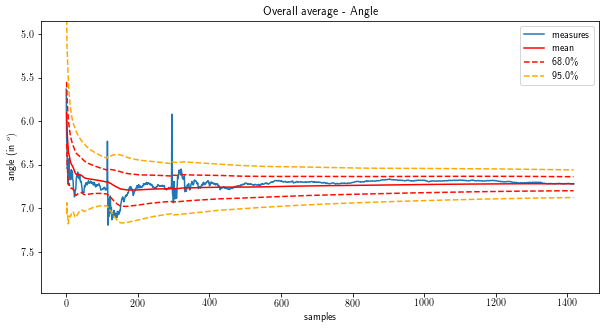

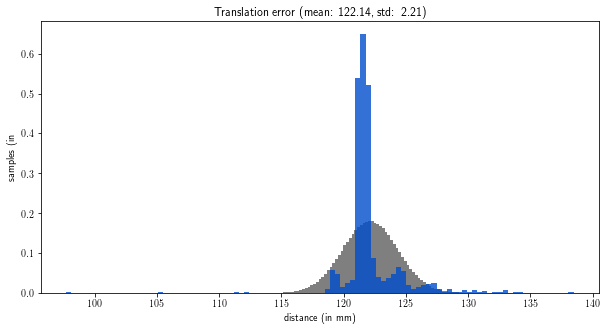

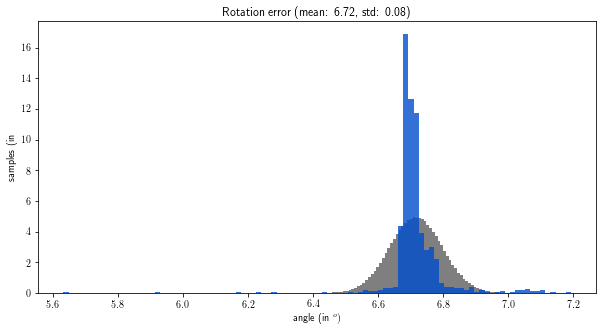

In [64]:
R = Reader('cam3_cam2-average.log', 'Overall average', conf=[0, 0.68, 0.95], std=False)

File cam3_cam2_filter01.log contains 500 lines of 7 variables.
Reducing data from 500 to 500 (100.00%)


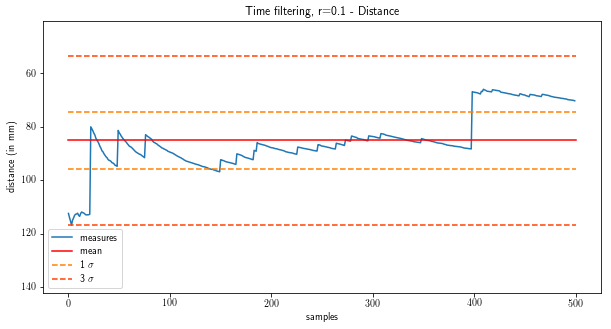

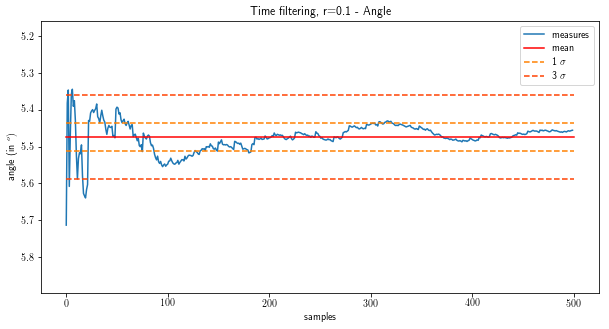

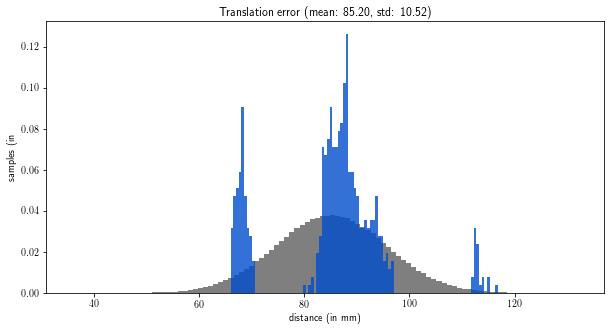

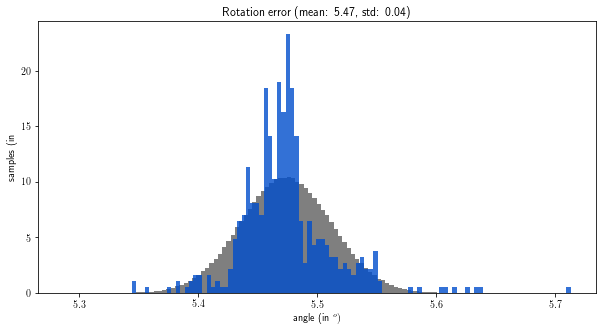

In [65]:
R = Reader('cam3_cam2_filter01.log', 'Time filtering, r=0.1')

File cam3_cam2.log contains 556 lines of 7 variables.
Reducing data from 556 to 556 (100.00%)


/users/promo2017/smaillot/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/users/promo2017/smaillot/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


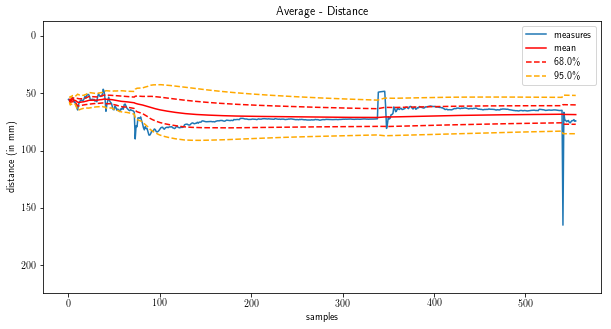

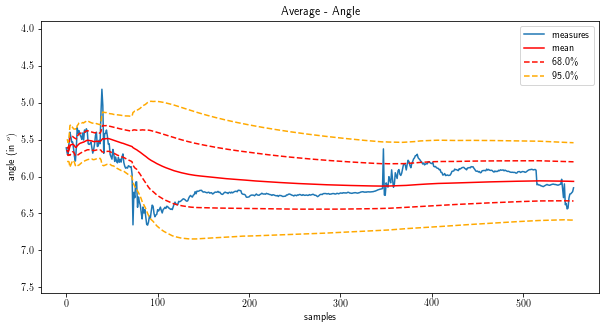

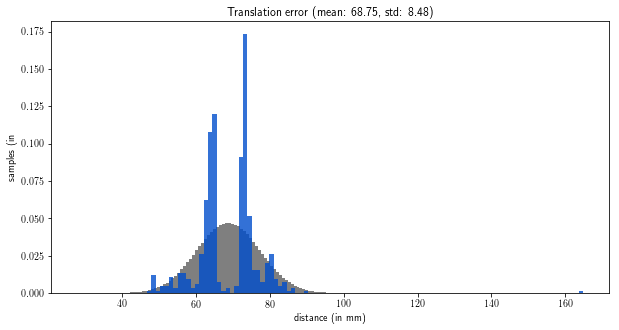

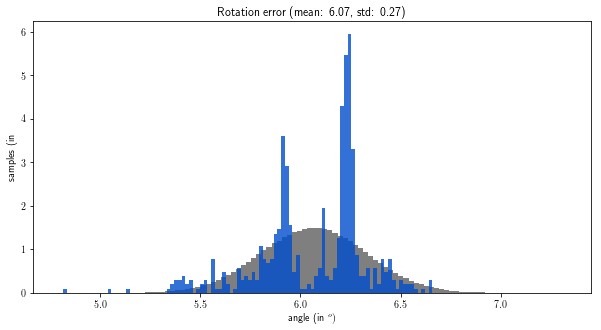

In [66]:
R = Reader('cam3_cam2.log', 'Average', [0, 0.68, 0.95], False)